## <center> Hybrid recommender models </center>

In [1]:
import warnings

warnings.filterwarnings("ignore")


import collections
import numpy as np
import os
import pandas as pd


from lightfm.data import Dataset
from lightfm import LightFM
from tqdm import tqdm_notebook

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

**Ключевая идея** - давайте попробуем учиться не только на взаимодействиях users и items, но и добавлять в модель имеющиеся по ним признаки.

Способов немало, но сегодня разберем LightFM

### MovieLens-1M

Источник: https://grouplens.org/datasets/movielens/1m/ с данными в трех файлах: users.dat, ratings.dat, movies.dat, которые мы объединились в один csv. 
Для быстроты вычислений на семинаре мы взяли первые 10к строк из датасета, но если будете воспроизводить у себя и захотите посмотреть на финальное качество модели, попробуйте поработать со всем датасетом. 





### LightFM. 

Kula, M., 2015. Metadata embeddings for user and item cold-start recommendations. arXiv preprint arXiv:1507.08439.

http://ceur-ws.org/Vol-1448/paper4.pdf?ref=https://githubhelp.com

https://github.com/lyst/lightfm

Нейросетевые модели - не всегда самая лучшая опция, в частности, есть довольно сильная модель LightFM, которая обобщает коллабративную фильтрацию для случая с добавлением признаков. 


* Это гибридный подход коллаборативной фильтрации и контентной модели, которая предсталвяет эмбеддинги пользователей и эмбеддинги объектов как линейные комбинации из обученных векторов известных признаков - т.е. суммы новых латентных признаков. При этом, это позволяет обучать модель как в режиме без признаков, так и с ними, решая проблему холодного старта (т.к. по новым пользователям и объектам можно использовать их признаки) и проблему слишком разреженных данных (high sparsity problem). Таким образом, LightFM умеет хорошо работает как с плотными, так и с разреженными данными, и, как бонус, кодировать в эмбеддингах признаков семантическую информацию по аналогии с подходами для получения эмбеддингов слов (например, w2v).


*  Формализация.  <br> $U$ - множество пользователей, <br> $I$ - множество объектов, <br> $F^{U}$ - множество признаков пользователей, <br> $F^{I}$- множество признаков объектов. <br>
Все пары $(u, i) \in U × I$ - это объединение всех положительных $S^{+}$ и отрицательных $S^{-}$ интеракций. 

Каждый пользователь описан набором заранее известных признаков (мета данных) $f_u \subset F^U$, то же самое для объектов  $f_i \subset F^I$.

Латентное представление пользователя представлено суммой его латентных векторов признаков: 

$$q_u = \sum_{j \in f_u} e^U_j$$

Аналогично для объектов: $$p_u = \sum_{j \in f_i} e^I_j$$

Помимо этого по пользователю и объекту есть смещения (bias): 

$$b_u = \sum_{j \in f_u} b^U_j$$

$$b_i = \sum_{j \in f_i} b^I_j$$

Предсказание из модели будем получать через скалярное произведение эмбедингов пользователя и объекта. 

$$\hat r_{ui} = f (q_u \cdot p_i + b_u + b_i)$$

Функция $f(x)$ может быть разной, автор статьи выбрал сигмоиду, поскольку использовал бинарные данные.

$$f(x) = \frac{1}{1 + exp(-x)}$$

Задача оптимизации будет сформулирована как максимизация правдоподобия (данных при параметрах), с обучением модели с помощью стохастического градиентного спуска.

$$L(e^U, e^I, b^U, b^I) = \prod_{(u, i) \in S^+} \hat r_{ui} \cdot  \prod_{(u, i) \in S^-} (1 - \hat r_{ui})$$

In [2]:
def df_to_tuple_iterator(df: pd.DataFrame):
    """
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    """
    return zip(*df.values.T)


def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])


def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [3]:
file_path = "ml-1m.csv"
data = pd.read_csv(file_path, nrows=10_000)
data["cat_id"] = data["genres"].apply(lambda x: x.split("|")[0])
data.head()

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip,cat_id
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067,Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067,Animation
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067,Musical
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067,Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067,Animation


In [4]:
interactions = data[["user_id", "movie_id", "rating", "timestamp"]]
interactions.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
movies_metadata = data[["movie_id", "cat_id", "title"]]
movies_metadata.head(3)

,movie_id,cat_id,title
0,1193,Drama,One Flew Over the Cuckoo's Nest (1975)
1,661,Animation,James and the Giant Peach (1996)
2,914,Musical,My Fair Lady (1964)


In [6]:
movies_metadata["movie_id"] = movies_metadata["movie_id"].astype(str)
interactions["movie_id"] = interactions["movie_id"].astype(str)

interactions_filtered = interactions.loc[interactions["movie_id"].isin(movies_metadata["movie_id"])]
print(interactions.shape, interactions_filtered.shape)

(10000, 4) (10000, 4)


In [49]:
help(Dataset)

Help on class Dataset in module rectools.dataset.dataset:

class Dataset(builtins.object)
 |  Dataset(user_id_map: rectools.dataset.identifiers.IdMap, item_id_map: rectools.dataset.identifiers.IdMap, interactions: rectools.dataset.interactions.Interactions, user_features: Union[rectools.dataset.features.DenseFeatures, rectools.dataset.features.SparseFeatures, NoneType] = None, item_features: Union[rectools.dataset.features.DenseFeatures, rectools.dataset.features.SparseFeatures, NoneType] = None) -> None
 |  
 |  Container class for all data for a recommendation model.
 |  
 |  It stores data about internal-external id mapping,
 |  user-item interactions, user and item features
 |  in special `rectools` structures for convenient future usage.
 |  
 |  WARNING: It's highly not recommended to create `Dataset` object directly.
 |  Use `construct` class method instead.
 |  
 |  Parameters
 |  ----------
 |  user_id_map : IdMap
 |      User identifiers mapping.
 |  item_id_map : IdMap
 |   

In [7]:
dataset = Dataset()
dataset.fit(interactions["user_id"].unique(), interactions["movie_id"].unique())
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    "users_mapping": lightfm_mapping[0],
    "user_features_mapping": lightfm_mapping[1],
    "items_mapping": lightfm_mapping[2],
    "item_features_mapping": lightfm_mapping[3],
}
print("user mapper length - ", len(lightfm_mapping["users_mapping"]))
print("user features mapper length - ", len(lightfm_mapping["user_features_mapping"]))
print("movies mapper length - ", len(lightfm_mapping["items_mapping"]))
print("Users movie features mapper length - ", len(lightfm_mapping["item_features_mapping"]))

user mapper length -  46
user features mapper length -  46
movies mapper length -  2175
Users movie features mapper length -  2175


In [8]:
lightfm_mapping["users_inv_mapping"] = {v: k for k, v in lightfm_mapping["users_mapping"].items()}
lightfm_mapping["items_inv_mapping"] = {v: k for k, v in lightfm_mapping["items_mapping"].items()}

In [9]:
train_mat, train_mat_weights = dataset.build_interactions(
    df_to_tuple_iterator(interactions_filtered[["user_id", "movie_id"]])
)

Set LightFM params:

In [10]:
NO_COMPONENTS = 64
LEARNING_RATE = 0.04
LOSS = "bpr"
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [11]:
lfm_model = LightFM(
    no_components=NO_COMPONENTS,
    learning_rate=LEARNING_RATE,
    loss=LOSS,
    max_sampled=MAX_SAMPLED,
    random_state=RANDOM_STATE,
)

In [12]:
for _ in tqdm_notebook(range(EPOCHS), total=EPOCHS):
    lfm_model.fit_partial(train_mat, num_threads=4)

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
# to make sanity-check
top_N = 10
user_id = interactions["user_id"][1000]
row_id = lightfm_mapping["users_mapping"][user_id]
print(f"Rekko for user {user_id}, row number in matrix - {row_id}")

Rekko for user 19, row number in matrix - 6


In [14]:
all_cols = list(lightfm_mapping["items_mapping"].values())
len(all_cols)

2175

In [15]:
pred = lfm_model.predict(row_id, all_cols, num_threads=4)
pred, pred.shape

(array([-2.7411578, -4.6428556, -5.109652 , ..., -5.176814 , -5.2269077,
        -5.426247 ], dtype=float32),
 (2175,))

In [16]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 97, 262,  37,  10,  23, 346, 365, 399, 496, 497])

In [17]:
pred[top_cols]

array([-1.7176727, -1.8814441, -1.8891894, -1.9242724, -2.149095 ,
       -2.1927822, -2.219572 , -2.2239392, -2.261821 , -2.3066013],
      dtype=float32)

In [18]:
# crate mapper for movieId and title names
item_name_mapper = dict(zip(movies_metadata["movie_id"], movies_metadata["title"]))

In [19]:
item_name_mapper

{'1193': "One Flew Over the Cuckoo's Nest (1975)",
 '661': 'James and the Giant Peach (1996)',
 '914': 'My Fair Lady (1964)',
 '3408': 'Erin Brockovich (2000)',
 '2355': "Bug's Life, A (1998)",
 '1197': 'Princess Bride, The (1987)',
 '1287': 'Ben-Hur (1959)',
 '2804': 'Christmas Story, A (1983)',
 '594': 'Snow White and the Seven Dwarfs (1937)',
 '919': 'Wizard of Oz, The (1939)',
 '595': 'Beauty and the Beast (1991)',
 '938': 'Gigi (1958)',
 '2398': 'Miracle on 34th Street (1947)',
 '2918': "Ferris Bueller's Day Off (1986)",
 '1035': 'Sound of Music, The (1965)',
 '2791': 'Airplane! (1980)',
 '2687': 'Tarzan (1999)',
 '2018': 'Bambi (1942)',
 '3105': 'Awakenings (1990)',
 '2797': 'Big (1988)',
 '2321': 'Pleasantville (1998)',
 '720': 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 '1270': 'Back to the Future (1985)',
 '527': "Schindler's List (1993)",
 '2340': 'Meet Joe Black (1998)',
 '48': 'Pocahontas (1995)',
 '1097': 'E.T. the Extra-Terrestrial (1982)',
 '1721': 'Titani

In [20]:
recs = pd.DataFrame({"col_id": top_cols})
recs["movie_id"] = recs["col_id"].map(lightfm_mapping["items_inv_mapping"].get).astype(str)
recs["title"] = recs["movie_id"].map(item_name_mapper)
recs

,col_id,movie_id,title
0,97,589,Terminator 2: Judgment Day (1991)
1,262,3623,Mission: Impossible 2 (2000)
2,37,1022,Cinderella (1950)
3,10,595,Beauty and the Beast (1991)
4,23,527,Schindler's List (1993)
5,346,3527,Predator (1987)
6,365,34,Babe (1995)
7,399,3175,Galaxy Quest (1999)
8,496,1036,Die Hard (1988)
9,497,1387,Jaws (1975)


In [21]:
recs = pd.DataFrame({"col_id": top_cols})
recs["movieId"] = recs["col_id"].map(lightfm_mapping["items_inv_mapping"].get).astype(str)
recs["title"] = recs["movieId"].map(item_name_mapper)
recs

,col_id,movieId,title
0,97,589,Terminator 2: Judgment Day (1991)
1,262,3623,Mission: Impossible 2 (2000)
2,37,1022,Cinderella (1950)
3,10,595,Beauty and the Beast (1991)
4,23,527,Schindler's List (1993)
5,346,3527,Predator (1987)
6,365,34,Babe (1995)
7,399,3175,Galaxy Quest (1999)
8,496,1036,Die Hard (1988)
9,497,1387,Jaws (1975)


Источники:

1. RecBole https://github.com/RUCAIBox/RecBole
2. https://github.com/datawhalechina/torch-rechub 
3. Статья LightFM http://ceur-ws.org/Vol-1448/paper4.pdf?ref=https://githubhelp.com
4. Отличная **библиотека от автора статьи** c примерами запусков - https://github.com/lyst/lightfm 

In [22]:
!pip install rectools

In [23]:
%%time
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip -O data_original.zip
!unzip -o data_original.zip
!rm data_original.zip

Archive:  data_original.zip
  inflating: data_original/interactions.csv  
  inflating: __MACOSX/data_original/._interactions.csv  
  inflating: data_original/users.csv  
  inflating: __MACOSX/data_original/._users.csv  
  inflating: data_original/items.csv  
  inflating: __MACOSX/data_original/._items.csv  
CPU times: user 220 ms, sys: 79.2 ms, total: 299 ms
Wall time: 11.4 s


In [24]:
import os
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from rectools.metrics import MAP, calc_metrics, MeanInvUserFreq, Serendipity
from rectools.models import ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from implicit.als import AlternatingLeastSquares

warnings.filterwarnings("ignore")
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # For implicit ALS
sns.set_theme(style="whitegrid")

In [25]:
DATA_PATH = Path("data_original")

users = pd.read_csv(DATA_PATH / "users.csv")
items = pd.read_csv(DATA_PATH / "items.csv")
interactions = pd.read_csv(DATA_PATH / "interactions.csv", parse_dates=["last_watch_dt"], nrows=20_000).rename(
    columns={"last_watch_dt": Columns.Datetime},
)

In [26]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [27]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [28]:
interactions.head()

,user_id,item_id,datetime,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [29]:
# Process interactions
interactions[Columns.Weight] = np.where(interactions["watched_pct"] > 10, 3, 1)

# Split to train / test
max_date = interactions[Columns.Datetime].max()
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()
train.drop(train.query("total_dur < 300").index, inplace=True)

cold_users = set(test[Columns.User]) - set(train[Columns.User])
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)
test_users = test[Columns.User].unique()
catalog = train[Columns.Item].unique()

# Process user features to the form of a flatten dataframe
users.fillna("Unknown", inplace=True)
users = users.loc[users[Columns.User].isin(train[Columns.User])].copy()
user_features_frames = []
for feature in ["sex", "age", "income"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)

# Process item features to the form of a flatten dataframe
items = items.loc[items[Columns.Item].isin(train[Columns.Item])].copy()
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
item_features = pd.concat((genre_feature, content_feature))

In [30]:
item_features

,id,value,feature
16,2904,зарубежные,genre
16,2904,мистика,genre
16,2904,ужасы,genre
38,1622,триллеры,genre
38,1622,детективы,genre
...,...,...,...
15942,3060,film,content_type
15943,2783,series,content_type
15955,5525,series,content_type
15958,6443,series,content_type


In [31]:
user_features.head()

,id,value,feature
3,721985,Ж,sex
66,216495,М,sex
122,702215,Ж,sex
172,988516,Ж,sex
176,652799,Ж,sex


In [32]:
item_features.head()

,id,value,feature
16,2904,зарубежные,genre
16,2904,мистика,genre
16,2904,ужасы,genre
38,1622,триллеры,genre
38,1622,детективы,genre


In [33]:
dataset_no_features = Dataset.construct(
    interactions_df=train,
)

dataset_full_features = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

dataset_item_features = Dataset.construct(
    interactions_df=train,
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

dataset_user_features = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
)

feature_datasets = {
    "full_features": dataset_full_features,
    "item_features": dataset_item_features,
    "user_features": dataset_user_features,
}

In [34]:
# Prepare dataset with biases as features

item_biases = pd.DataFrame({"id": catalog, "bias": 1})
user_biases = pd.DataFrame({"id": train[Columns.User].unique(), "bias": 1})

dataset_with_biases = Dataset.construct(
    interactions_df=train,
    user_features_df=user_biases,
    make_dense_user_features=True,
    item_features_df=item_biases,
    make_dense_item_features=True,
)
feature_datasets["biases"] = dataset_with_biases

In [35]:
metrics_name = {"MAP": MAP, "Serendipity": Serendipity}
metrics = {}
for metric_name, metric in metrics_name.items():
    for k in (1, 5, 10):
        metrics[f"{metric_name}@{k}"] = metric(k=k)

In [36]:
K_RECOS = 10
NUM_THREADS = 8
RANDOM_STATE = 42
ITERATIONS = 10

In [37]:
def make_base_model(factors: int, regularization: float, alpha: float, fit_features_together: bool = False):
    return ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            alpha=alpha,
            random_state=RANDOM_STATE,
            use_gpu=False,
            num_threads=NUM_THREADS,
            iterations=ITERATIONS,
        ),
        fit_features_together=fit_features_together,
    )

In [38]:
alphas = [1, 10, 100]
regularizations = [0.01, 0.1]
factors = [32, 64, 128]
results = []
dataset = dataset_no_features

for alpha in alphas:
    for regularization in regularizations:
        for n_factors in factors:
            model_name = f"no_features_factors_{n_factors}_alpha_{alpha}_reg_{regularization}"
            model = make_base_model(factors=n_factors, regularization=regularization, alpha=alpha)
            model.fit(dataset)
            recos = model.recommend(
                users=test_users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=True,
            )
            metric_values = calc_metrics(metrics, recos, test, train, catalog)
            metric_values["model"] = model_name
            results.append(metric_values)

In [39]:
pure_df = pd.DataFrame(results).set_index("model").sort_values(by=["MAP@10", "Serendipity@10"], ascending=False)
pure_df.head(5)

,MAP@1,MAP@5,MAP@10,Serendipity@1,Serendipity@5,Serendipity@10
model,,,,,,
no_features_factors_32_alpha_10_reg_0.01,0.017241,0.017241,0.019704,0.000012,0.000002,0.000021
no_features_factors_32_alpha_10_reg_0.1,0.017241,0.017241,0.019704,0.000012,0.000002,0.000021
no_features_factors_32_alpha_1_reg_0.01,0.017241,0.017241,0.017241,0.000298,0.000060,0.000030
no_features_factors_128_alpha_1_reg_0.01,0.000000,0.005747,0.008210,0.000000,0.000062,0.000057
no_features_factors_128_alpha_1_reg_0.1,0.000000,0.005747,0.008210,0.000000,0.000062,0.000057


In [40]:
# Best grid search params for pure iALS models
factors_options = (32, 64, 128)
ALPHA = 10
REG = 0.5

# We have two options for training iALS with features in RecTools
fit_features_together = (True, False)

# We have datasets with different feature selections
feature_datasets.keys()

dict_keys(['full_features', 'item_features', 'user_features', 'biases'])

In [41]:
features_results = []
for dataset_name, dataset in feature_datasets.items():
    for n_factors in factors_options:
        for features_option in fit_features_together:
            model_name = f"{dataset_name}_factors_{n_factors}_fit_together_{features_option}"
            model = make_base_model(
                factors=n_factors, regularization=REG, alpha=ALPHA, fit_features_together=features_option
            )
            model.fit(dataset)
            recos = model.recommend(
                users=test_users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=True,
            )
            metric_values = calc_metrics(metrics, recos, test, train, catalog)
            metric_values["model"] = model_name
            features_results.append(metric_values)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
features_df = (
    pd.DataFrame(features_results).set_index("model").sort_values(by=["MAP@10", "Serendipity@10"], ascending=False)
)
features_df.head(5)

,MAP@1,MAP@5,MAP@10,Serendipity@1,Serendipity@5,Serendipity@10
model,,,,,,
biases_factors_64_fit_together_False,0.017241,0.031609,0.033525,0.000000,0.000001,0.000001
biases_factors_32_fit_together_False,0.017241,0.024138,0.026054,0.000012,0.000002,0.000002
user_features_factors_32_fit_together_False,0.017241,0.021552,0.025431,0.000012,0.000002,0.000041
full_features_factors_32_fit_together_False,0.017241,0.021552,0.023467,0.000012,0.000002,0.000022
biases_factors_128_fit_together_False,0.000000,0.022989,0.022989,0.000000,0.000000,0.000000


In [43]:
# prepare info for summary plot
no_features_best_models = [
    "no_features_factors_128_alpha_10_reg_0.5",
    "no_features_factors_64_alpha_10_reg_0.5",
    "no_features_factors_32_alpha_10_reg_0.5",
]

pure_df["step"] = "1. pure iALS no features grid search"
pure_df.loc[pure_df.index.isin(no_features_best_models), "step"] = "2. pure iALS no features best models"
features_df["step"] = "3. iALS with user / item features"
all_df = pd.concat([features_df, pure_df])

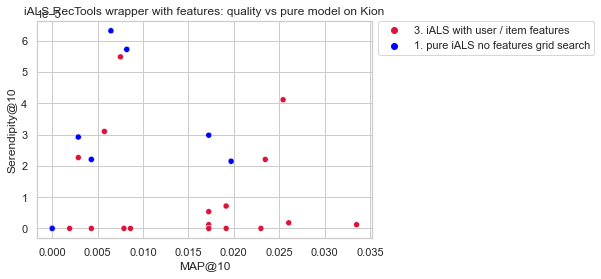

In [44]:
sns.scatterplot(data=all_df, x="MAP@10", y="Serendipity@10", hue="step", palette=["crimson", "blue", ])
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("iALS RecTools wrapper with features: quality vs pure model on Kion")
plt.show()

На полных данных будет вот так красиво:  

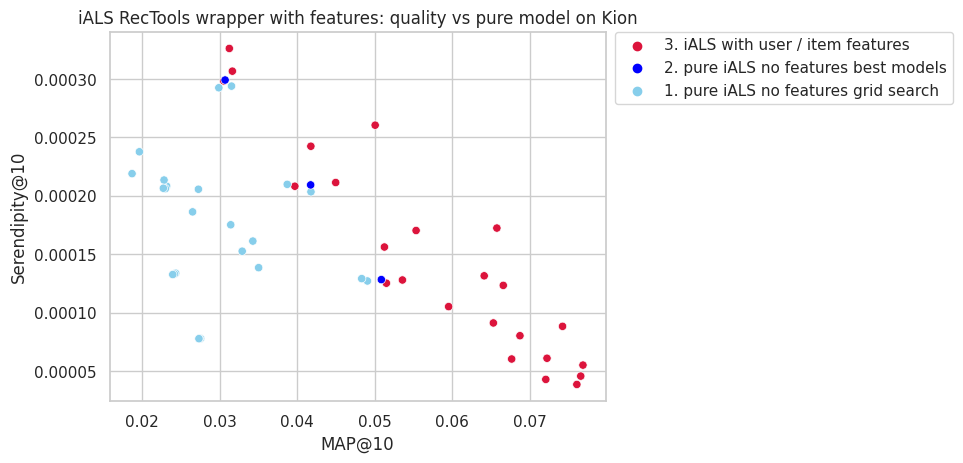